### Step 1: Load the package

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from google.cloud import bigquery
from google.cloud import bigquery_storage
from run_sql_queries import run_query_func
import datetime as dt
from datetime import datetime
import re
import warnings
from math import ceil
warnings.filterwarnings(action = 'ignore')

g:\My Drive\APAC\Autopricing\Switchback Testing\switchback_test_dag\venv_sb\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


### Step 2.1: Define some input parameters

In [4]:
# General inputs
query_path = "G:\My Drive\APAC\Autopricing\Switchback Testing\switchback_test_dag\sql_queries\data_extraction_queries_automated_script.sql" # This is the path to the BQ script that pulls test data

# Define the list of KPIs
col_list = [
    'actual_df_paid_by_customer', 'gfv_local', 'gmv_local', 'commission_local', 'joker_vendor_fee_local', # Customer KPIs (1)
    'sof_local', 'service_fee_local', 'revenue_local', 'delivery_costs_local', 'gross_profit_local', # Customer KPIs (2)
    'dps_mean_delay', 'delivery_distance_m', 'actual_DT' # Logistics KPIs
]

params = [
    {'exp_name': 'TH_20220721_R_F0_O_Switchback_AA_Test_Trang', 'exp_start': dt.date(2022, 7, 21), 'exp_end': dt.date(2022, 8, 17)},
    {'exp_name': 'PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition', 'exp_start': dt.date(2022, 7, 22), 'exp_end': dt.date(2022, 8, 18)},
]

schemes_for_surge_setups = "'FP_TH | 2997', 'FP_PH | 2072'"

start_date = dt.date(2022, 8, 31)
end_date = dt.date(2022, 9, 27)

### Step 2.2: Run the query

In [50]:
run_query_func(query_path)

The SQL script was executed successfully at 2022-09-30 17:24:24.489923 



### Step 3.0: Download the test data

In [3]:
client = bigquery.Client(project = "logistics-data-staging-flat")
bqstorage_client = bigquery_storage.BigQueryReadClient()

query = """
    SELECT 
        a.*,
        b.dps_travel_time_fee_local,
        b.dps_surge_fee_local
    FROM `dh-logistics-product-ops.pricing.ab_test_individual_orders_cleaned_switchback_tests` AS a
    LEFT JOIN `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` b ON a.entity_id = b.entity_id AND a.platform_order_code = b.platform_order_code
"""
df = client.query(query).result().to_dataframe(bqstorage_client=bqstorage_client)

### Step 3.1: Change the data types of columns in the dataset

In [4]:
# Define the start of the data frame where the data types of columns need to be changed 
col_start = np.where(df.columns == 'exchange_rate')[0][0]

# Change data types --> df[df.cols = specific cols].apply(pd.to_numeric)
df[df.columns[col_start:]] = df[df.columns[col_start:]].apply(pd.to_numeric, errors = 'ignore')

### Step 3.2: Retrieve the switchback test configurations

In [5]:
# The switchback_test_configs_bq table gets updated every hour via a scheduled query
sb_test_configs = client.query("""SELECT * FROM `dh-logistics-product-ops.pricing.switchback_test_configs_bq`""")\
    .result()\
    .to_dataframe(bqstorage_client = bqstorage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/2 [00:00<?, ?rows/s]

### Step 3.3: Extract the scheme IDs from between the curly brackets

In [6]:
# Apply the extraction function on the "scheme_id_on" and "scheme_id_off" columns
sb_test_configs['scheme_id_on'] = sb_test_configs['scheme_id_on'].apply(lambda x: re.findall('\{(.*?)\}', x)[0])
sb_test_configs['scheme_id_off'] = sb_test_configs['scheme_id_off'].apply(lambda x: re.findall('\{(.*?)\}', x)[0])

### Step 3.4: Create a list of dicts storing the config info of the switchback tests

In [7]:
# Declare an empty dict that will be contain the details of a particular switchback test in each for loop iteration
# The keys of the dict are the column names of sb_test_configs
test_config_dict = {}
keys = list(sb_test_configs.columns)

# Declare an empty list that will contain all the dicts storing the test config information
test_config_lod = []

# Populate the list of dicts (lod) with the test configuration info
for i in range(0, len(sb_test_configs.index)): # Enumerate over the number of tests
    for key in keys: # Populate an intermediary dict with the config info of the test belonging to the current iteration
        test_config_dict[key] = sb_test_configs[key][i]
    test_config_lod.append(test_config_dict) # Append the intermediary dict to the list of dicts
    test_config_dict = {} # Empty the dict so that it can be populated again

### Step 3.5: Amend the structure of the list of dicts so that "zone" and "scheme" columns contain lists instead of strings

In [8]:
for test in range(0, len(test_config_lod)): # Iterate over the test dicts
    for key in ['zone_name_vendor_excl', 'zone_name_customer_excl', 'scheme_id_on', 'scheme_id_off']: # Iterate over these keys specifically to change their contents to a list
        if test_config_lod[test][key] == None: # If the value of the key is None, change it to an empty list
            test_config_lod[test][key] = []
        else: 
            test_config_lod[test][key] = test_config_lod[test][key].split(', ') # Split the components of the string into list elements
        
        if 'scheme_id' in key: # If the key being accessed contains the word "scheme_id", change the components of the list to integers using list comprehension
            test_config_lod[test][key] = [int(sch) for sch in test_config_lod[test][key]]
        else:
            pass

### Step 4.1: Create a function that produces time intervals

In [8]:
def hr_interval_func_random(sb_interval):
    bins = int(24 / sb_interval) # The number of bins by which we will divide the range from 0 to 24. A 2-hour switchback interval will have 12 bin --> [0, 2), [2, 4), [4, 6), ... [22, 24)
    if sb_interval >= 1:
        end_of_range = 25
    elif sb_interval == 0.5:
        end_of_range = 24.5
    elif sb_interval == 0.25:
        end_of_range = 24.25
    df_mapping = pd.DataFrame(data = {
            'hr_interval': list(pd.cut(np.arange(0, end_of_range, sb_interval), bins = bins, right = False)) # The bins should be closed from the left
        }
    )

    # Drop duplicates
    df_mapping.drop_duplicates(inplace = True)

    unique_intervals = df_mapping['hr_interval'].unique()
    on_off_list = ['On', 'Off'] * ceil(len(unique_intervals) / 2) # Create the full list that the rng.choice would choose from

    rng = np.random.default_rng()
    df_mapping['treatment_status_by_time'] = rng.choice(on_off_list, replace = False, axis = 0, size = len(df_mapping))
    return df_mapping

# Create a function that returns the right hr_interval from df_mapping for any given number
def check_right_interval(num, col):
    for i in col:
        if num in i:
            return i
        else:
            pass

### Step 4.2: Create a function that extracts the clean data of one test

In [9]:
# Create a function that extracts the clean data of one test
def df_clean_func(df, test_name, test_start, test_end, sb_interval_hr):
    """
    A function that cleans the data by filtering for the relevant orders based on the test configurations in this G-sheet
    https://docs.google.com/spreadsheets/d/1JeHPeEFUhDaatvCJqqWBgLxRbe_7kLQkObj-lGEX5X0/edit#gid=0
    """
    pos = [iter['test_name'] for iter in test_config_lod].index(test_name) # Get the index of the test's data in test_config_lod
    
    df_temp = df[
        (df['target_group'] != 'Non_TG') &
        (df['test_name'] == test_config_lod[pos]['test_name']) &
        (~ df['zone_name_vendor'].isin(test_config_lod[pos]['zone_name_vendor_excl'])) &
        (~ df['zone_name_customer'].isin(test_config_lod[pos]['zone_name_customer_excl'])) &
        ((df['scheme_id'].isin(test_config_lod[pos]['scheme_id_on'])) | (df['scheme_id'].isin(test_config_lod[pos]['scheme_id_off']))) &
        (df['order_placed_at_local'].dt.date.between(test_config_lod[pos]['test_start'], test_config_lod[pos]['test_end']))
    ] # Filter out Non_TG orders because they will contain irrelevant price schemes

    # We will add a supplementary column to "df_temp" in the for loop below, so we need to create a function with the conditions
    on_off_conditions = [
        (df_temp['scheme_id'].isin(test_config_lod[pos]['scheme_id_on'])),
        (df_temp['scheme_id'].isin(test_config_lod[pos]['scheme_id_off']))
    ]

    # Add a supplementary column to indicate if the order belonged to an 'On' or 'Off' day
    df_temp['on_or_off_day'] = np.select(on_off_conditions, ['On', 'Off'])

    # Create a new column with the located created_date of the order 
    df_temp['order_created_date_local'] = df_temp['order_placed_at_local'].dt.date

    # Filter for the data between test_start and test_end
    df_temp = df_temp[df_temp['order_created_date_local'].between(test_start, test_end)]

    # Create the mapping data frame that has the 'On'/'Off' flag for each time interval
    df_mapping = hr_interval_func_random(sb_interval = sb_interval_hr)

    # Get the hour from the "order_placed_at_local" column
    df_temp['hr_of_day'] = round(df_temp['order_placed_at_local'].dt.hour + df_temp['order_placed_at_local'].dt.minute / 60 + df_temp['order_placed_at_local'].dt.second / 3600, 2)

    # Get the right interval using the "check_right_interval" function
    df_temp['hr_interval'] = df_temp.apply(lambda x: check_right_interval(x['hr_of_day'], df_mapping['hr_interval'].unique()), axis = 1)

    return df_temp

### Step 5: Create a function that adds a few columns to the cleaned dataset

In [11]:
df_clean_th = df_clean_func(df, 'TH_20220721_R_F0_O_Switchback_AA_Test_Trang', test_start = params[0]['exp_start'], test_end = params[0]['exp_end'], sb_interval_hr = 0.25)
df_clean_th_surge_only = df_clean_th[df_clean_th['dps_surge_fee_local'] > 0]

df_clean_ph = df_clean_func(df, 'PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition', test_start = params[1]['exp_start'], test_end = params[1]['exp_end'], sb_interval_hr = 0.25)
df_clean_ph_surge_only = df_clean_ph[df_clean_ph['dps_surge_fee_local'] > 0]

### Step 6.1: Download the travel time and mean delay thresholds of the surge setup

In [12]:
surge_query = """
    SELECT
        a.region,
        a.entity_id,
        a.country_code,
        a.* EXCEPT (region, entity_id, country_code),
        DENSE_RANK() OVER (PARTITION BY a.entity_id, a.country_code, a.scheme_id, a.delay_config_id ORDER BY a.tt_threshold) AS tt_tier,
        DENSE_RANK() OVER (PARTITION BY a.entity_id, a.country_code, a.scheme_id, a.delay_config_id, tt_threshold ORDER BY a.delay_threshold) AS delay_tier,
    FROM (
        SELECT DISTINCT
            ps.region,
            ps.entity_id,
            ps.country_code,
            ps.scheme_id,
            h.scheme_name,
            TIMESTAMP_TRUNC(h.active_from, SECOND) AS scheme_active_from,
            TIMESTAMP_TRUNC(h.active_to, SECOND) AS scheme_active_to,
            h.delay_config_id,
            dc.name AS config_name,
            TIMESTAMP_TRUNC(dc.active_from, SECOND) AS tt_config_active_from,
            TIMESTAMP_TRUNC(dc.active_to, SECOND) AS tt_config_active_to,
            COALESCE(dd.travel_time_threshold, 9999999) AS tt_threshold,
            CASE
                WHEN dd.travel_time_threshold IS NULL THEN 9999999
                ELSE ROUND(FLOOR(dd.travel_time_threshold) + (dd.travel_time_threshold - FLOOR(dd.travel_time_threshold)) * 60 / 100, 2)
            END AS tt_threshold_in_min_and_sec,
            COALESCE(dd.delay_threshold, 9999999) AS delay_threshold,
            CASE
                WHEN dd.delay_threshold IS NULL THEN 9999999
                ELSE ROUND(FLOOR(dd.delay_threshold) + (dd.delay_threshold - FLOOR(dd.delay_threshold)) * 60 / 100, 2)
            END AS delay_threshold_in_min_and_sec,
            dd.delay_fee AS fee,
            TIMESTAMP_TRUNC(dd.active_from, SECOND) AS delay_detail_active_from,
            TIMESTAMP_TRUNC(dd.active_to, SECOND) AS delay_detail_active_to
        FROM `fulfillment-dwh-production.cl.dps_config_versions` AS ps
        LEFT JOIN UNNEST(price_scheme_history) AS h
        LEFT JOIN UNNEST(delay_history) AS dh
        LEFT JOIN UNNEST(delay_config) AS dc
        LEFT JOIN UNNEST(delay_detail) AS dd
        WHERE TRUE
            AND h.active_to IS NULL
            AND dc.active_to IS NULL
            AND dd.active_to IS NULL
            AND CONCAT(ps.entity_id, " | ", ps.scheme_id) IN (""" + schemes_for_surge_setups + """) 
        QUALIFY
            TIMESTAMP_TRUNC(h.active_from, SECOND) = MAX(TIMESTAMP_TRUNC(h.active_from, SECOND)) OVER (PARTITION BY ps.entity_id, ps.country_code, ps.scheme_id)
            AND TIMESTAMP_TRUNC(dc.active_from, SECOND) = MAX(TIMESTAMP_TRUNC(dc.active_from, SECOND)) OVER (PARTITION BY ps.entity_id, ps.country_code, ps.scheme_id)
    -- Don't filter for the latest travel time detail record(s) via another QUALIFY statement because this occasionally removes relevant TT tiers
    ) AS a
    ORDER BY region, entity_id, country_code, scheme_id, tt_tier, delay_tier
    ;
"""
df_surge = client.query(surge_query).result().to_dataframe(bqstorage_client = bqstorage_client)

# Change data types --> df[df.cols = specific cols].apply(pd.to_numeric)
df_surge_col_list = ["tt_threshold", "tt_threshold_in_min_and_sec", "delay_threshold", "delay_threshold_in_min_and_sec", "fee"]
df_surge[df_surge_col_list] = df_surge[df_surge_col_list].apply(pd.to_numeric, errors = 'ignore')

### Step 6.2: Analyze the surge dynamics

Text(0.5, 1.0, 'Surge Heatmap PH')

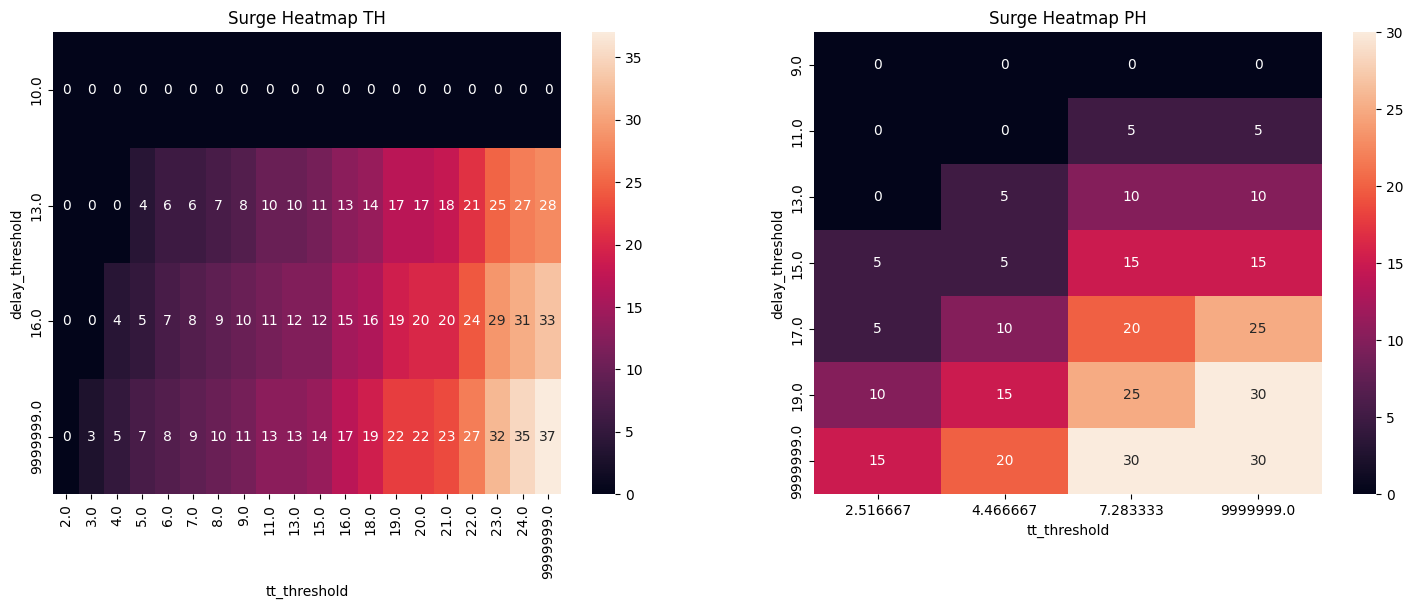

In [13]:
# Surge pivots
df_surge_pivot_th = df_surge[df_surge['scheme_id'] == 2997].pivot_table(index = 'delay_threshold', columns = 'tt_threshold', values = 'fee')
df_surge_pivot_ph = df_surge[df_surge['scheme_id'] == 2072].pivot_table(index = 'delay_threshold', columns = 'tt_threshold', values = 'fee')

# Surge heat maps
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.heatmap(df_surge_pivot_th, ax = ax[0], annot = True)
ax[0].set_title('Surge Heatmap TH')
sns.heatmap(df_surge_pivot_ph, ax = ax[1], annot = True)
ax[1].set_title('Surge Heatmap PH')

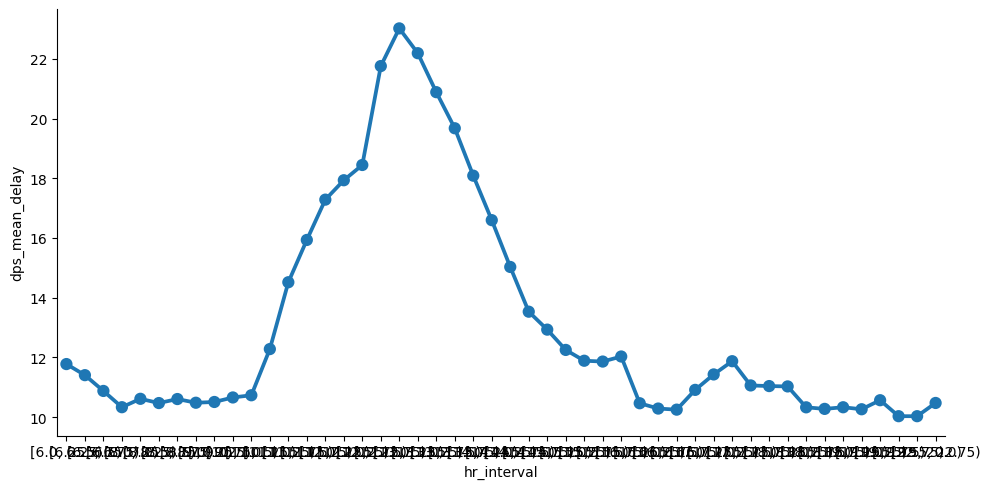

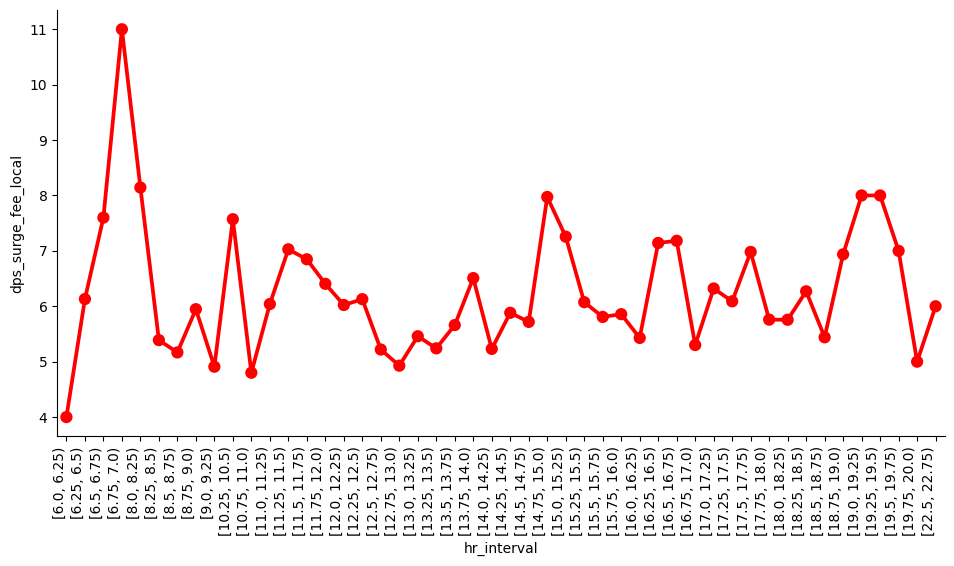

In [14]:
x = df_clean_th_surge_only[df_clean_th_surge_only['dow_local'] == 'Monday'].groupby('hr_interval')['dps_mean_delay', 'travel_time', 'dps_surge_fee_local'].mean().reset_index()
sns.catplot(data = x, x = 'hr_interval', y = 'dps_mean_delay', kind = 'point', aspect = 2)
sns.catplot(data = x, x = 'hr_interval', y = 'dps_surge_fee_local', kind = 'point', aspect = 2, color = 'red')
plt.xticks(rotation = 90, ha = 'right')
plt.show()

### Create a data frame containing the normalized values of the number of surged by hr_interval and DoW

In [46]:
df_norm_surged_orders = df_clean_ph_surge_only.groupby(['hr_interval', 'dow_local'])['platform_order_code'].nunique().to_frame(name = 'surged_order_count').reset_index()
df_norm_surged_orders = df_norm_surged_orders.pivot_table(index = 'hr_interval', columns = 'dow_local', values = 'surged_order_count', fill_value = 0)
# Normalize the values
df_norm_surged_orders = df_norm_surged_orders.apply(lambda x: (x - min(x)) / (max(x) - min(x)))

### Step 6.3: Upload the data frames to GBQ so that they can be exported to Tableau

In [58]:
df_clean_th_upload = df_clean_th
df_clean_ph_upload = df_clean_ph

# Change column types
df_clean_th_upload['hr_interval'] = df_clean_th_upload['hr_interval'].astype(str)
df_clean_ph_upload['hr_interval'] = df_clean_ph_upload['hr_interval'].astype(str)

# Since string columns use the "object" dt_obj_obj_objype, pass in a (partial) schema to ensure the correct BigQuery data type.
job_config = bigquery.LoadJobConfig()

# Set the job_config to overwrite the data in the table
job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

# Upload the p-values dataframe to BQ 
job1 = client.load_table_from_dataframe(
    dataframe = df_clean_th_upload.reset_index(drop = True),
    destination = 'dh-logistics-product-ops.pricing.df_clean_th_switchback_test_propagation_effect',
    job_config = job_config
)

job1.result() # Wait for the load job to complete

job2 = client.load_table_from_dataframe(
    dataframe = df_clean_ph_upload.reset_index(drop = True),
    destination = 'dh-logistics-product-ops.pricing.df_clean_ph_switchback_test_propagation_effect',
    job_config = job_config
)

job2.result() # Wait for the load job to complete

LoadJob<project=logistics-data-staging-flat, location=US, id=ccb941b5-a9ce-4d6c-8c86-5b23947dacdf>

### Step 6.4: Random Zones

In [5]:
client = bigquery.Client(project = 'dh-logistics-product-ops')
bq_storage_client = bigquery_storage.BigQueryReadClient()

df_random_zones = client.query("""SELECT * FROM `dh-logistics-product-ops.pricing.ab_test_individual_orders_augmented_additional_deep_dives`""")\
    .result()\
    .to_dataframe(bqstorage_client = bq_storage_client)

### Step 6.5: Create the cleaning function

In [6]:
def df_clean_random_zones_func(df, sb_interval_hr): # sb_groupby_col could be 'on_or_off_day' or 'treatment_status_by_time' 
    # Create a new column with the located created_date of the order 
    df['order_created_date_local'] = df['order_placed_at_local'].dt.date

    # Filter for the data between test_start and test_end
    df = df[df['order_created_date_local'].between(start_date, end_date)]

    # Create the mapping data frame that has the 'On'/'Off' flag for each time interval
    df_mapping = hr_interval_func_random(sb_interval = sb_interval_hr)

    # Get the hour from the "order_placed_at_local" column
    df['hr_of_day'] = round(df['order_placed_at_local'].dt.hour + df['order_placed_at_local'].dt.minute / 60 + df['order_placed_at_local'].dt.second / 3600, 2)
    
    # Get the right interval using the "check_right_interval" function
    df['hr_interval'] = df.apply(lambda x: check_right_interval(x['hr_of_day'], df_mapping['hr_interval'].unique()), axis = 1)

    return df

In [10]:
# Run the function
df_random_zones_clean = df_clean_random_zones_func(df_random_zones, 0.25)

#### Step 6.6: Upload the dataframe to BQ so that it can be used in Tableau 

In [12]:
# Change column types
df_random_zones_clean['hr_interval'] = df_random_zones_clean['hr_interval'].astype(str)

# Since string columns use the "object" dt_obj_obj_objype, pass in a (partial) schema to ensure the correct BigQuery data type.
job_config = bigquery.LoadJobConfig()

# Set the job_config to overwrite the data in the table
job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

# Upload the p-values dataframe to BQ 
job1 = client.load_table_from_dataframe(
    dataframe = df_random_zones_clean.reset_index(drop = True),
    destination = 'dh-logistics-product-ops.pricing.df_clean_random_zones_switchback_test_propagation_effect',
    job_config = job_config
)

job1.result() # Wait for the load job to complete

LoadJob<project=dh-logistics-product-ops, location=US, id=accc0f93-687c-44e2-9b4c-6fc48c449b6d>